### Feed-Forward Neural Network on CIFAR Data

First, import some libraries and some functions to get pretty looking plots

In [7]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

# Make matplotlib plot pretty pictures
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 14.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Neural Network Definition

A neural network class needs to have two functions - 

1. `__init__` : Here, you specify the size of the net, and the number and type of layers it has.
    * We have one hidden layer of size `hidden_size`, the `input_size` and the output size is `num_classes`.
    
2. `forward` : Define the forward propagation through your layers.
    
    * In the example below, there's a fully-connected layer -> RELU -> fully-connected layer -> output

In [2]:
# Neural Network Model (1 hidden layer)
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

#### Hyperparameters

* `num_epochs` : The number of sweeps of your entire training data you wish to do.
* `batch_size` : The number of datapoints you take for each SGD step
* There could be other hyperparameters as well, such as learning rate decay.

In [3]:
# Hyper Parameters 
input_size = 32*32*3
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

#### Working with the CIFAR10 Dataset

1. Download the data, and split it into training and test sets
2. Plot some images in the CIFAR10 set, to understand what we're dealing with.

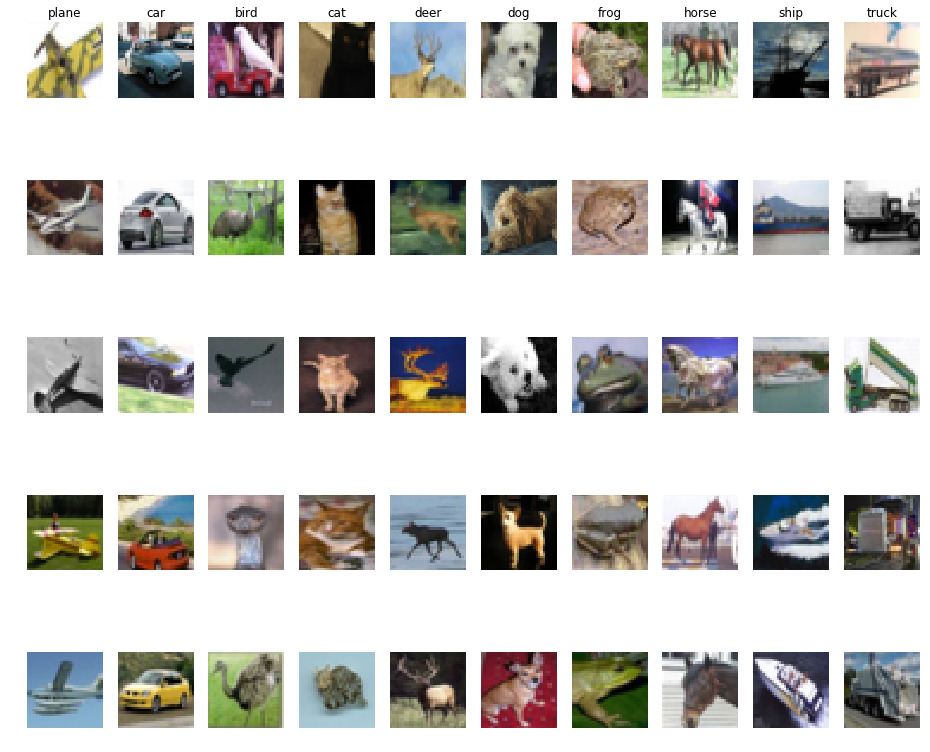

In [4]:
# CIFAR10 Dataset 
train_dataset = dsets.CIFAR10(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),  
                            download=False)

test_dataset = dsets.CIFAR10(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Explore the data
data_iter = iter(train_loader)

# Mini-batch images and labels.
images, labels = data_iter.next()

# Explore the CIFAR Data
X_train = 255*np.moveaxis(images.numpy(), 1, -1)
y_train = labels.numpy()

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 5
for y, cls in enumerate(classes):
	ids = np.flatnonzero(y_train == y)
	ids = np.random.choice(ids, samples_per_class, replace=False)

	for i, idxs in enumerate(ids):
		plt_idx = i*num_classes+y+1
		plt.subplot(samples_per_class, num_classes, plt_idx)
		plt.imshow(X_train[idxs].astype('uint8'))
		plt.axis('off')
		if i == 0:
			plt.title(cls)

plt.show()

In [6]:
# Initialize and train the neural network

net = Net(input_size, hidden_size, num_classes)
net.cuda()   # Tells PyTorch to use the GPU instead of the CPU 
    
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()   # This is softmax loss
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)  

# Train the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Convert torch tensor to Variable
        images = Variable(images.view(-1, 32*32*3).cuda()) #.cuda() just tells Pytorch to shift everything to the GPU
        labels = Variable(labels.cuda())
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

# Test the Model
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, 32*32*3)).cuda()
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

# Save the Model
torch.save(net.state_dict(), 'model.pkl')

Epoch [1/5], Step [100/500], Loss: 2.2972
Epoch [1/5], Step [200/500], Loss: 2.2712
Epoch [1/5], Step [300/500], Loss: 2.2524
Epoch [1/5], Step [400/500], Loss: 2.2528
Epoch [1/5], Step [500/500], Loss: 2.2202
Epoch [2/5], Step [100/500], Loss: 2.2096
Epoch [2/5], Step [200/500], Loss: 2.2303
Epoch [2/5], Step [300/500], Loss: 2.1476
Epoch [2/5], Step [400/500], Loss: 2.1720
Epoch [2/5], Step [500/500], Loss: 2.1439
Epoch [3/5], Step [100/500], Loss: 2.1602
Epoch [3/5], Step [200/500], Loss: 2.1574
Epoch [3/5], Step [300/500], Loss: 2.1618
Epoch [3/5], Step [400/500], Loss: 2.0455
Epoch [3/5], Step [500/500], Loss: 2.1083
Epoch [4/5], Step [100/500], Loss: 2.1127
Epoch [4/5], Step [200/500], Loss: 2.0713
Epoch [4/5], Step [300/500], Loss: 2.1236
Epoch [4/5], Step [400/500], Loss: 2.0828
Epoch [4/5], Step [500/500], Loss: 2.0815
Epoch [5/5], Step [100/500], Loss: 2.1147
Epoch [5/5], Step [200/500], Loss: 2.1200
Epoch [5/5], Step [300/500], Loss: 2.0284
Epoch [5/5], Step [400/500], Loss: